# Test HAC-Net

This notebook allows one to test HAC-Net on any dataset that we provide, or any other dataset of the same format and preprocessing requirements. In this notebook, we test on the PDBbind 2016 core set. 

## Set Up Notebook

In [1]:
# install torch packages necessary for GCNs
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 106 kB 39.3 MB/s 
     |████████████████████████████████| 208 kB 49.0 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp38-cp38-linux_x86_64.whl size=3398132 sha256=9f9bf40c686b2db3bb2820d19817b7918c7eb365444308c7a42ff67accab5274
  Stored in directory: /root/.cache/pip/wheels/41/7f/4f/cf072bea3b6efe4561de2db3603ebbd8718c134c24caab8281
  Created wheel for torch-sparse: filename=torch_sparse-0.6.16-cp38-cp38-linux_x86_64.whl size=2508617 sha256=c61b85e410197b2bb438a86dff51303c9208f0ed30fe2cf023229330b2dc593a
  Stored in directory: /root/.cache/pip/wheels/d7/f5/41/86610d3a3ce0bec241d8549ecdd6c7e07fe000e041616cfcd6
Successfully built torch-scatter torch-sparse
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████

In [2]:
# import packages
import torch
from torch.utils.data import Dataset
import os
import h5py
from sklearn.metrics import pairwise_distances
from torch_geometric.nn.conv import MessagePassing, GatedGraphConv
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import add_self_loops
from torch_geometric.nn.aggr import AttentionalAggregation
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch_geometric.nn import DataParallel as GeometricDataParallel
from torch_geometric.data import DataListLoader, Data
from torch_geometric.utils import dense_to_sparse
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy as sp
from scipy.stats import *
from sklearn.metrics import *

In [12]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Containers

In [3]:
''' Define a class to contain the data that will be included in the dataloader 
sent to the GCN model '''

class GCN_Dataset(Dataset):
  
    def __init__(self, data_file):
        super(GCN_Dataset, self).__init__()
        self.data_file = data_file
        self.data_dict = {}
        self.data_list = []
        
        # retrieve PDB id's and affinities from hdf file
        with h5py.File(data_file, 'r') as f:
            for pdbid in f.keys():
                affinity = np.asarray(f[pdbid].attrs['affinity']).reshape(1, -1)
                self.data_list.append((pdbid, affinity))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, item):

        
        if item in self.data_dict.keys():
            return self.data_dict[item]

        pdbid, affinity = self.data_list[item]
        node_feats, coords = None, None

        coords=h5py.File(self.data_file,'r')[pdbid][:,0:3]
        dists=pairwise_distances(coords, metric='euclidean')
        
        self.data_dict[item] = (pdbid, dists)
        return self.data_dict[item]

In [4]:
""" Define a class to contain the data that will be included in the dataloader 
sent to the 3D-CNN """

class CNN_Dataset(Dataset):

	def __init__(self, hdf_path, feat_dim=22):
		super(CNN_Dataset, self).__init__()
		self.hdf_path = hdf_path
		self.feat_dim = feat_dim
		self.hdf = h5py.File(self.hdf_path, 'r')
		self.data_info_list = []
    # append PDB id and affinity label to data_info_list
		for pdbid in self.hdf.keys():
			affinity = float(self.hdf[pdbid].attrs['affinity'])
			self.data_info_list.append([pdbid, affinity])

	def close(self):
		self.hdf.close()

	def __len__(self):
		count = len(self.data_info_list)
		return count
		
	def get_data_info_list(self):
		return self.data_info_list

	def __getitem__(self, idx):
		pdbid, affinity = self.data_info_list[idx]

		data = self.hdf[pdbid][:]
		x = torch.tensor(data)
		x = x.permute(3,0,1,2)
		y = torch.tensor(np.expand_dims(affinity, axis=0))
		return x,y, pdbid

In [5]:
""" Define a class to contain the extracted 3D-CNN features that will be included in the dataloader 
sent to the fully-connected network """

class Linear_Dataset(Dataset):
	def __init__(self, npy_path, feat_dim=22):
		super(Linear_Dataset, self).__init__()
		self.npy_path = npy_path
		self.input_feat_array = np.load(npy_path, allow_pickle=True)[:,:-1].astype(np.float32)
		self.input_affinity_array = np.load(npy_path, allow_pickle=True)[:,-1].astype(np.float32)
		self.data_info_list = []
    


	def __len__(self):
		count = self.input_feat_array.shape[0]
		return count


	def __getitem__(self, idx):
		data, affinity = self.input_feat_array[idx], self.input_affinity_array[idx]

		x = torch.tensor(data)
		y = torch.tensor(np.expand_dims(affinity, axis=0))
		return x,y

## Model Architecture

In [6]:
""" Define GCN architecture class """

class MP_GCN(torch.nn.Module):

    def __init__(self, in_channels, gather_width=128, prop_iter=4, dist_cutoff=3.5):
        super(MP_GCN, self).__init__()

        #define distance cutoff
        self.dist_cutoff=torch.Tensor([dist_cutoff])
        if torch.cuda.is_available():
            self.dist_cutoff = self.dist_cutoff.cuda()

        #Attentional aggregation
        self.gate_net = nn.Sequential(nn.Linear(in_channels, int(in_channels/2)), nn.Softsign(), nn.Linear(int(in_channels/2), int(in_channels/4)), nn.Softsign(), nn.Linear(int(in_channels/4),1))
        self.attn_aggr = AttentionalAggregation(self.gate_net)
        
        #Gated Graph Neural Network
        self.gate = GatedGraphConv(in_channels, prop_iter, aggregation=self.attn_aggr)

        #Simple neural networks for use in asymmetric attentional aggregation
        self.attn_net_i=nn.Sequential(nn.Linear(in_channels * 2, in_channels), nn.Softsign(),nn.Linear(in_channels, gather_width), nn.Softsign())
        self.attn_net_j=nn.Sequential(nn.Linear(in_channels, gather_width), nn.Softsign())

        #Final set of linear layers for making affinity prediction
        self.output = nn.Sequential(nn.Linear(gather_width, int(gather_width / 1.5)), nn.ReLU(), nn.Linear(int(gather_width / 1.5), int(gather_width / 2)), nn.ReLU(), nn.Linear(int(gather_width / 2), 1))

    def forward(self, data):

        #Move data to GPU
        if torch.cuda.is_available():
            data.x = data.x.cuda()
            data.edge_attr = data.edge_attr.cuda()
            data.edge_index = data.edge_index.cuda()
            data.batch = data.batch.cuda()

        # allow nodes to propagate messages to themselves
        data.edge_index, data.edge_attr = add_self_loops(data.edge_index, data.edge_attr.view(-1))

        # restrict edges to the distance cutoff
        row, col = data.edge_index
        mask = data.edge_attr <= self.dist_cutoff
        mask = mask.squeeze()
        row, col, edge_feat = row[mask], col[mask], data.edge_attr[mask]
        edge_index=torch.stack([row,col],dim=0)

        # propagation
        node_feat_0 = data.x
        node_feat_1 = self.gate(node_feat_0, edge_index, edge_feat)
        node_feat_attn = torch.nn.Softmax(dim=1)(self.attn_net_i(torch.cat([node_feat_1, node_feat_0], dim=1))) * self.attn_net_j(node_feat_0)

        # globally sum features and apply linear layers
        pool_x = global_add_pool(node_feat_attn, data.batch)
        prediction = self.output(pool_x)

        return prediction

In [7]:
""" Define 3D-CNN architecture class """

class Model_3DCNN(nn.Module):

  def __conv_filter__(self, in_channels, out_channels, kernel_size, stride, padding):
    conv_filter = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True), nn.ReLU(inplace=True), nn.BatchNorm3d(out_channels))
    return conv_filter

  def __init__(self, feat_dim=19, output_dim=1, use_cuda=True):
    super(Model_3DCNN, self).__init__()     
    self.feat_dim = feat_dim
    self.output_dim = output_dim
    self.use_cuda = use_cuda
    
    # SE block
    self.conv_block1 = self.__conv_filter__(self.feat_dim, 64, 9, 2, 3)
    self.glob_pool1 = nn.AdaptiveAvgPool3d(1)
    self.SE_block1 = nn.Linear(in_features=64, out_features=64//16, bias=False)
    self.relu = nn.ReLU()
    self.SE_block1_ = nn.Linear(in_features=64//16, out_features=64, bias=False)
    self.sigmoid = nn.Sigmoid()

    # residual blocks
    self.res_block1 = self.__conv_filter__(64, 64, 7, 1, 3)
    self.res_block2 = self.__conv_filter__(64, 64, 7, 1, 3)

    # SE block
    self.conv_block2 = self.__conv_filter__(64, 128, 7, 3, 3)
    self.glob_pool = nn.AdaptiveAvgPool3d(1)
    self.SE_block2 = nn.Linear(in_features=128, out_features=128//16, bias=False)
    self.SE_block2_ = nn.Linear(in_features=128//16, out_features=128, bias=False)
    self.max_pool = nn.MaxPool3d(2)

    ## SE block
    self.conv_block3 = self.__conv_filter__(128, 256, 5, 2, 2)
    self.SE_block3 = nn.Linear(in_features=256, out_features=256//16, bias=False)
    self.SE_block3_ = nn.Linear(in_features=256//16, out_features=256, bias=False)

    # dense layers
    self.linear1 = nn.Linear(2048, 100)
    torch.nn.init.normal_(self.linear1.weight, 0, 1)
    self.linear1_bn = nn.BatchNorm1d(num_features=100, affine=True, momentum=0.1).train()
    self.linear2 = nn.Linear(100, 1)
    torch.nn.init.normal_(self.linear2.weight, 0, 1)

  def forward(self, x):
    if x.dim() == 1:
      x = x.unsqueeze(-1)

    # SE block 1
    conv1 = self.conv_block1(x)
    a1,b1, _, _, _ = conv1.shape
    glob_pool_conv1 = self.glob_pool(conv1).view(a1, b1)
    SE_block1 = self.SE_block1(glob_pool_conv1)   
    SE_block1a = self.relu(SE_block1)
    SE_block1_ = self.SE_block1_(SE_block1a)
    SE_block1_a = self.sigmoid(SE_block1_).view(a1, b1, 1, 1, 1)  
    se1 = conv1 * SE_block1_a.expand_as(conv1)  

    # residual blocks
    conv1_res1 = self.res_block1(se1)
    conv1_res12 = conv1_res1 + se1
    conv1_res2 = self.res_block2(conv1_res12)
    conv1_res2_2 = conv1_res2 + se1

    # SE block 2
    conv2 = self.conv_block2(conv1_res2_2)
    a2,b2, _, _, _ = conv2.shape
    glob_pool_conv2 = self.glob_pool(conv2).view(a2, b2)
    SE_block2 = self.SE_block2(glob_pool_conv2)        
    SE_block2a = self.relu(SE_block2)
    SE_block2_ = self.SE_block2_(SE_block2a)
    SE_block2_a = self.sigmoid(SE_block2_).view(a2, b2, 1, 1, 1)  
    se2 = conv2 * SE_block2_a.expand_as(conv2)  

    # Pooling layer
    pool2 = self.max_pool(se2)

    # SE block 3
    conv3 = self.conv_block3(pool2)
    a3,b3, _, _, _ = conv3.shape
    glob_pool_conv3 = self.glob_pool(conv3).view(a3, b3)
    SE_block3 = self.SE_block3(glob_pool_conv3)       
    SE_block3a = self.relu(SE_block3)
    SE_block3_ = self.SE_block3_(SE_block3a)
    SE_block3_a = self.sigmoid(SE_block3_).view(a3, b3, 1, 1, 1)  
    se3 = conv3 * SE_block3_a.expand_as(conv3)  

    # Pooling layer
    pool3 = se3

    # Flatten
    flatten = pool3.view(pool3.size(0), -1)

    # Linear layer 1
    linear1_z = self.linear1(flatten)
    linear1_y = self.relu(linear1_z)
    linear1 = self.linear1_bn(linear1_y) if linear1_y.shape[0]>1 else linear1_y

    # Linear layer 2
    linear2_z = self.linear2(linear1)

    return linear2_z, flatten

In [8]:
""" Define fully-connected network class """
class Model_Linear(nn.Module):
	def __init__(self, use_cuda=True):
		super(Model_Linear, self).__init__()     
		self.use_cuda = use_cuda

		self.fc1 = nn.Linear(2048, 100)
		torch.nn.init.normal_(self.fc1.weight, 0, 1)
		self.dropout1 = nn.Dropout(0.0)
		self.fc1_bn = nn.BatchNorm1d(num_features=100, affine=True, momentum=0.3).train()
		self.fc2 = nn.Linear(100, 1)
		torch.nn.init.normal_(self.fc2.weight, 0, 1)
		self.relu = nn.ReLU()


	def forward(self, x):
		fc1_z = self.fc1(x)
		fc1_y = self.relu(fc1_z)
		fc1_d = self.dropout1(fc1_y)
		fc1 = self.fc1_bn(fc1_d) if fc1_d.shape[0]>1 else fc1_d  #batchnorm train require more than 1 batch
		fc2_z = self.fc2(fc1)
		return fc2_z, fc1_z

## Test Function

In [121]:
def test_hybrid(test, cnn_test_path, gcn0_test_path, gcn1_test_path, cnn_checkpoint_path, gcn0_checkpoint_path, gcn1_checkpoint_path):

    """
    Define a function to test HAC-Net, the 3D-CNN component, or one of the two GCN components
    
    Inputs:
    1) test: either "hybrid", "cnn", "gcn0", or "gcn1"    
    2) cnn_test_path: path to cnn test set npy file
    3) gcn0_test_path: path to gcn0 test set hdf file
    4) gcn1_test_path: path to gcn1 test set hdf file
    5) cnn_checkpoint_path: path to cnn checkpoint file
    6) gcn0_checkpoint_path: path to gcn0 checkpoint file
    7) gcn1_checkpoint_path: path to gcn1 checkpoint file
    Output:
    1) Print statement of summary of evaluation: RMSE, MAE, r^2, Pearson r, Spearman p, Mean, SD
    2) Correlation scatter plot of experimental vs predicted values
    """

    # set CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    cuda_count = torch.cuda.device_count()
    device_name = "cuda:0"
    if use_cuda:
        device = torch.device(device_name)
        torch.cuda.set_device(int(device_name.split(':')[1]))
    else:   
        device = torch.device('cpu')  

    if test == 'hybrid' or 'cnn':
        # 3D-CNN
        batch_size = 50
        # load dataset
        cnn_dataset = Linear_Dataset(cnn_test_path)
        # initialize data loader
        batch_count = len(cnn_dataset) // batch_size
        cnn_dataloader = DataLoader(cnn_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=None)
        # define model
        cnn_model = Model_Linear(use_cuda=use_cuda)
        cnn_model.to(device)
        if isinstance(cnn_model, (DistributedDataParallel, DataParallel)):
            cnn_model = cnn_model.module
        # load checkpoint file
        cnn_checkpoint = torch.load(cnn_checkpoint_path, map_location=device)
        # model state dict
        cnn_model_state_dict = cnn_checkpoint.pop("model_state_dict")
        cnn_model.load_state_dict(cnn_model_state_dict, strict=False)
        # create empty arrays to hold predicted and true values
        y_true_cnn = np.zeros((len(cnn_dataset),), dtype=np.float32)
        y_pred_cnn = np.zeros((len(cnn_dataset),), dtype=np.float32)
        pdbid_arr = np.zeros((len(cnn_dataset),), dtype=object)
        pred_list = []
        cnn_model.eval()
        with torch.no_grad():
            for batch_ind, batch in enumerate(cnn_dataloader):
                x_batch_cpu, y_batch_cpu = batch
                x_batch, y_batch = x_batch_cpu.to(device), y_batch_cpu.to(device)
                bsize = x_batch.shape[0]
                ypred_batch, _ = cnn_model(x_batch[:x_batch.shape[0]])
                ytrue = y_batch_cpu.float().data.numpy()[:,0]
                ypred = ypred_batch.cpu().float().data.numpy()[:,0]
                y_true_cnn[batch_ind*batch_size:batch_ind*batch_size+bsize] = ytrue
                y_pred_cnn[batch_ind*batch_size:batch_ind*batch_size+bsize] = ypred

    if test == 'hybrid' or 'gcn0':
        # GCN-0
        gcn0_dataset = GCN_Dataset(gcn0_test_path)
        # initialize testing data loader
        batch_count = len(gcn0_dataset) // batch_size
        gcn0_dataloader = DataListLoader(gcn0_dataset, batch_size=7, shuffle=False)
        # define model
        gcn0_model = GeometricDataParallel(MP_GCN(in_channels=20, gather_width=128, prop_iter=4, dist_cutoff=3.5)).float()
        # load checkpoint file
        gcn0_checkpoint = torch.load(gcn0_checkpoint_path, map_location=device)
        # model state dict
        gcn0_model_state_dict = gcn0_checkpoint.pop("model_state_dict")
        gcn0_model.load_state_dict(gcn0_model_state_dict, strict=False)
        test_data_hdf = h5py.File(gcn0_test_path, 'r')
        gcn0_model.eval()
        y_true_gcn0, y_pred_gcn0, pdbid_array = [], [], []
        with torch.no_grad():
            for batch in tqdm(gcn0_dataloader):
                data_list = []
                for dataset in batch:
                    pdbid = dataset[0]
                    pdbid_array.append(pdbid)
                    affinity = test_data_hdf[pdbid].attrs["affinity"].reshape(1,-1)
                    vdw_radii = (test_data_hdf[pdbid].attrs["van_der_waals"].reshape(-1, 1))
                    node_feats = np.concatenate([vdw_radii, test_data_hdf[pdbid][:, 3:22]], axis=1)
                    edge_index, edge_attr = dense_to_sparse(torch.from_numpy(dataset[1]).float()) 
                    x = torch.from_numpy(node_feats).float()
                    y = torch.FloatTensor(affinity).view(-1, 1)
                    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr.view(-1, 1), y=y)
                    data_list.append(data)
                batch_data = [x for x in data_list if x is not None]
                y_ = gcn0_model(batch_data)
                y = torch.cat([x.y for x in data_list])
                y_true_gcn0.append(y.cpu().data.numpy())
                y_pred_gcn0.append(y_.cpu().data.numpy())
        y_true_gcn0 = np.concatenate(y_true_gcn0).reshape(-1, 1).squeeze(1)
        y_pred_gcn0 = np.concatenate(y_pred_gcn0).reshape(-1, 1).squeeze(1)

    if test == 'hybrid' or 'gcn1':
        # GCN-1
        gcn1_dataset = GCN_Dataset(gcn1_test_path)
        # initialize testing data loader
        batch_count = len(gcn0_dataset) // batch_size
        gcn1_dataloader = DataListLoader(gcn1_dataset, batch_size=7, shuffle=False)
        # define model
        gcn1_model = GeometricDataParallel(MP_GCN(in_channels=20, gather_width=128, prop_iter=4, dist_cutoff=3.5)).float()
        # load checkpoint file
        gcn1_checkpoint = torch.load(gcn1_checkpoint_path, map_location=device)
        # model state dict
        gcn1_model_state_dict = gcn1_checkpoint.pop("model_state_dict")
        gcn1_model.load_state_dict(gcn1_model_state_dict, strict=False)
        test_data_hdf = h5py.File(gcn1_test_path, 'r')
        gcn1_model.eval()
        y_true_gcn1, y_pred_gcn1, pdbid_array = [], [], []
        with torch.no_grad():
            for batch in tqdm(gcn1_dataloader):
                data_list = []
                for dataset in batch:
                    pdbid = dataset[0]
                    pdbid_array.append(pdbid)
                    affinity = test_data_hdf[pdbid].attrs["affinity"].reshape(1,-1)
                    vdw_radii = (test_data_hdf[pdbid].attrs["van_der_waals"].reshape(-1, 1))
                    node_feats = np.concatenate([vdw_radii, test_data_hdf[pdbid][:, 3:22]], axis=1)
                    edge_index, edge_attr = dense_to_sparse(torch.from_numpy(dataset[1]).float()) 
                    x = torch.from_numpy(node_feats).float()
                    y = torch.FloatTensor(affinity).view(-1, 1)
                    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr.view(-1, 1), y=y)
                    data_list.append(data)
                batch_data = [x for x in data_list if x is not None]
                y_ = gcn1_model(batch_data)
                y = torch.cat([x.y for x in data_list])
                y_true_gcn1.append(y.cpu().data.numpy())
                y_pred_gcn1.append(y_.cpu().data.numpy())
        y_true_gcn1 = np.concatenate(y_true_gcn1).reshape(-1, 1).squeeze(1)
        y_pred_gcn1 = np.concatenate(y_pred_gcn1).reshape(-1, 1).squeeze(1)

    # compute metrics
    if test == 'hybrid':
        y_true = y_true_cnn/3 + y_true_gcn0/3 + y_true_gcn1/3
        y_pred = y_pred_cnn/3 + y_pred_gcn0/3 + y_pred_gcn1/3
        # define rmse
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        # define mae
        mae = mean_absolute_error(y_true, y_pred)
        # define r^2
        r2 = r2_score(y_true, y_pred)
        # define pearson correlation coefficient
        pearson, ppval = pearsonr(y_true, y_pred)
        # define spearman correlation coefficient
        spearman, spval = spearmanr(y_true, y_pred)
        # define mean
        mean = np.mean(y_pred)
        # define standard deviation
        std = np.std(y_pred)

    if test == 'cnn':
        y_true = y_true_cnn
        y_pred = y_pred_cnn
        # define rmse
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        # define mae
        mae = mean_absolute_error(y_true, y_pred)
        # define r^2
        r2 = r2_score(y_true, y_pred)
        # define pearson correlation coefficient
        pearson, ppval = pearsonr(y_true, y_pred)
        # define spearman correlation coefficient
        spearman, spval = spearmanr(y_true, y_pred)
        # define mean
        mean = np.mean(y_pred)
        # define standard deviation
        std = np.std(y_pred)

    if test == 'gcn0':
        y_true = y_true_gcn0
        y_pred = y_pred_gcn0
        # define rmse
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        # define mae
        mae = mean_absolute_error(y_true, y_pred)
        # define r^2
        r2 = r2_score(y_true, y_pred)
        # define pearson correlation coefficient
        pearson, ppval = pearsonr(y_true, y_pred)
        # define spearman correlation coefficient
        spearman, spval = spearmanr(y_true, y_pred)
        # define mean
        mean = np.mean(y_pred)
        # define standard deviation
        std = np.std(y_pred)

    if test == 'gcn1':
        y_true = y_true_gcn1
        y_pred = y_pred_gcn1
        # define rmse
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        # define mae
        mae = mean_absolute_error(y_true, y_pred)
        # define r^2
        r2 = r2_score(y_true, y_pred)
        # define pearson correlation coefficient
        pearson, ppval = pearsonr(y_true, y_pred)
        # define spearman correlation coefficient
        spearman, spval = spearmanr(y_true, y_pred)
        # define mean
        mean = np.mean(y_pred)
        # define standard deviation
        std = np.std(y_pred)

    # print test summary
    print('Test Summary:')
    print('RMSE: %.3f, MAE: %.3f, r^2 score: %.3f, Pearson r: %.3f, Spearman p: %.3f, Mean: %.3f, SD: %.3f' % (rmse, mae, r2, pearson, spearman, mean, std))

    #print scatterplot of true and predicted values
    plt.rcParams["figure.figsize"] = (7,7)
    plt.scatter(y_true, y_pred, color='firebrick', edgecolors='black')       # color = firebrick if VANILLA
    plt.xlabel("Experimental", fontsize=20)
    plt.ylabel("Predicted", fontsize=20)
    plt.xticks([0,3,6,9,12], fontsize=18)
    plt.yticks([0,3,6,9,12], fontsize=18)
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.plot(np.arange(15), np.arange(15), color='dimgray', linestyle='-',zorder=0, linewidth=2)
    plt.title('HAC-Net', fontsize=26, weight='bold')
    plt.text(0.5,13.,'RMSE = '+"%.3f" % rmse, fontsize=18, weight='bold', color='firebrick')
    plt.text(0.5,12.1,'MAE = '+"%.3f" % mae, fontsize=18, weight='bold', color='firebrick')
    plt.text(0.5,11.2,'$r^{2}$ = '+"%.3f" % r2, fontsize=18, weight='bold', color='firebrick')
    plt.text(0.5,10.3,'$r$ ='+"%.3f" % pearson, fontsize=18, weight='bold', color='firebrick')
    plt.text(0.5,9.4,r'$\rho$ = '+"%.3f" % spearman, fontsize=18, weight='bold', color='firebrick')

## Test

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)
100%|██████████| 42/42 [00:03<00:00, 11.21it/s]
/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)
100%|██████████| 42/42 [00:03<00:00, 11.71it/s]


Test Summary:
RMSE: 1.202, MAE: 0.967, r^2 score: 0.694, Pearson r: 0.834, Spearman p: 0.828, Mean: 6.404, SD: 1.719


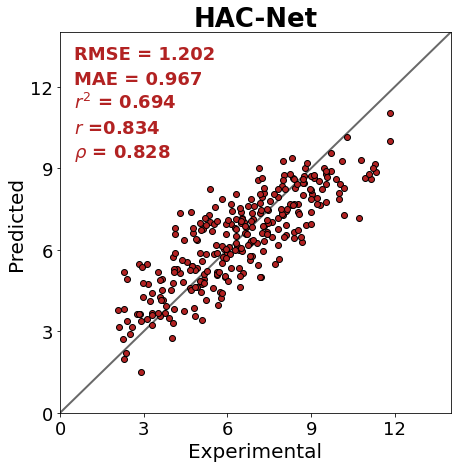

In [122]:
# test HAC-Net on PDBbind 2016 core set benchmark

test_hybrid(test='hybrid',
            cnn_test_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/3D-CNN_extracted_features/test on core 2016/cnn0_features_core_core.npy',
            gcn0_test_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/train_val_test_files/MP-GCN/test_on_core_2016/2016_core.hdf',
            gcn1_test_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/train_val_test_files/MP-GCN/test_on_core_2016/2016_core.hdf',
            cnn_checkpoint_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/parameter_files/3D-CNN/test on 2016 core/cnn_core2016.pt',
            gcn0_checkpoint_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/parameter_files/MP-GCN/test_on_core_2016/gcn0_core2016.pt',
            gcn1_checkpoint_path = '/content/drive/MyDrive/HAC-Net/HAC-Net_files/parameter_files/MP-GCN/test_on_core_2016/gcn1_core2016.pt')